In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from modules.galactic2icrs import cartesianGalactic_to_ICRS_torch
from modules import pairwise_min_velocity_diff, pairwise_min_velocity_diff_torch
from modules import Trafo

In [27]:
N = 5_000
mu = np.array([
    # X  Y  Z
    1000, 1000, 1000,
    # U V  W
    1, 2, -1
])
# Dispersion in X
sx = 1
# Velocity dispersion
sv = 1
C = np.diag([sx, sx, sx, sv, sv, sv])

# This is the Cartesian space where we should cluster in --> the latent space learned by the AE
data = pd.DataFrame(
    np.random.multivariate_normal(mu, C, N),
    columns=['X', 'Y', 'Z', 'U', 'V', 'W']
)

data_icrs = Trafo().cart2spher(data.values)

In [30]:
# We can then transform into the observed space using the transformation function below

# It might be useful to add an MSE term into the loss for the actual observations (ra, dec, plx, pmra, pmdec)
# since we also have these measurements, and it could make the network more robust.
# Another loss could be on the shape of the radial velocities (rv) distribution. We have some observed rvs and
# we expect that the distribution of the latent rvs should be similar to the observed one.
# This could maybe be done using a Wasserstein distance between the two samples from (ideally the same distribution).

# Transformation with custom function
data_torch = torch.tensor(data.values, dtype=torch.float32)[None, :]
# Create two batches out of data_torch
# data_torch_batched = torch.cat([*data_torch.chunk(2, dim=1)], dim=0)
half    = N // 2
batch1  = data_torch[:, :half, :]    # (1, N/2, D)
batch2  = data_torch[:, half:, :]    # (1, N/2, D)
# fuse back along the same axis
data_torch_batched = torch.cat([batch1, batch2], dim=0)

z = cartesianGalactic_to_ICRS_torch(data_torch_batched)
ra, dec, parallax, pmra, pmdec, _ = z.view(1, -1, 6).unbind(-1)  # shapes (B,N)
dist = 1000.0 / parallax                          # pc

In [31]:
data_torch_batched.shape

torch.Size([2, 2500, 6])

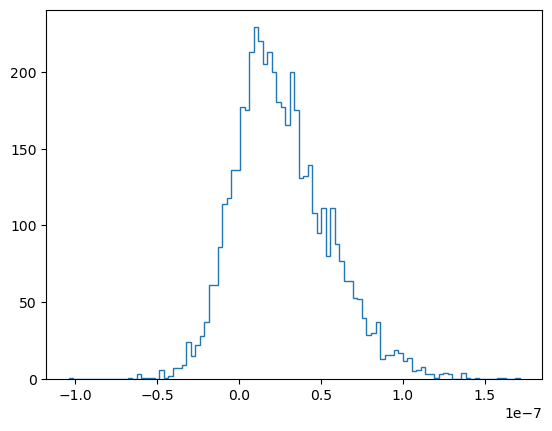

In [32]:
plt.hist(pmdec - data_icrs['pmdec'].values, bins=100, label='RA', color='tab:blue', histtype='step');

# Compute minimal difference of the 3D velocity vectors

In [33]:
D_t = pairwise_min_velocity_diff_torch(z)

In [34]:
D_t.requires_grad

False

In [35]:
D_t[0][:5, :5]

tensor([[0.0000, 1.0069, 0.3965, 0.4151, 1.5206],
        [1.0068, 0.0000, 1.4197, 0.5678, 2.2518],
        [0.3963, 1.4197, 0.0000, 0.9350, 1.2778],
        [0.4167, 0.5677, 0.9351, 0.0000, 1.9449],
        [1.5373, 2.0176, 1.2778, 1.9440, 0.0000]])

In [36]:
D_old = pairwise_min_velocity_diff(
    ra=ra[:,:N//2].numpy().ravel(),
    dec=dec[:,:N//2].numpy().ravel(),
    pmra=pmra[:,:N//2].numpy().ravel(),
    pmdec=pmdec[:,:N//2].numpy().ravel(),
    dist=dist[:,:N//2].numpy().ravel(),
)

/Users/ratzenboe/Documents/work/code/DeepSemiMetric/modules/pairwise_min_cartesian_velocity.py:251: RuntimeWarning: divide by zero encountered in divide
  vr_m = x_num / x_den
/Users/ratzenboe/Documents/work/code/DeepSemiMetric/modules/pairwise_min_cartesian_velocity.py:261: RuntimeWarning: divide by zero encountered in divide
  vr_n = y_num / y_den
/Users/ratzenboe/Documents/work/code/DeepSemiMetric/modules/pairwise_min_cartesian_velocity.py:263: RuntimeWarning: invalid value encountered in subtract
  norm2 = (a*vr_m - b*vr_n + c)**2 + (d*vr_m - e*vr_n + f)**2 + (g*vr_m - h*vr_n + i)**2


In [37]:
D_old[:5, :5]

array([[0.        , 1.00684237, 0.39678079, 0.41404814, 1.5267905 ],
       [1.00684237, 0.        , 1.41986382, 0.56815678, 1.20858896],
       [0.39678079, 1.41986382, 0.        , 0.93505466, 1.27786303],
       [0.41404814, 0.56815678, 0.93505466, 0.        , 1.94305754],
       [1.5267905 , 1.20858896, 1.27786303, 1.94305754, 0.        ]])

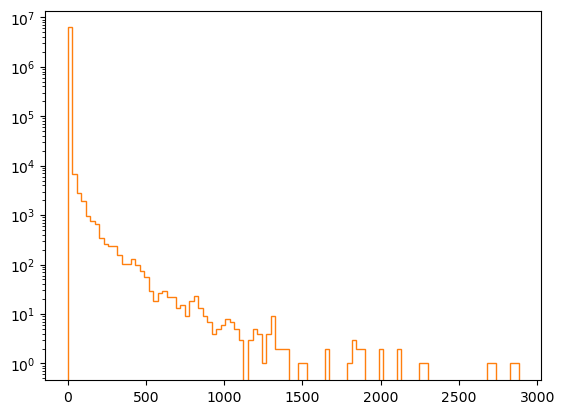

In [44]:
plt.hist(np.ravel(D_t[0] - D_old)**2, bins=100, histtype='step', label='diff', color='tab:orange', log=True);

In [41]:
np.nanmean((np.log(D_t[0]) - np.log(D_old))**2)

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_63074/3576368521.py:1: RuntimeWarning: divide by zero encountered in log
  np.nanmean((np.log(D_t[0]) - np.log(D_old))**2)
/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_63074/3576368521.py:1: RuntimeWarning: invalid value encountered in subtract
  np.nanmean((np.log(D_t[0]) - np.log(D_old))**2)


0.03384676428286427

In [24]:
# np.allclose(np.ravel(D_t.numpy()[0] - D_old), 0, atol=1e-5)

np.nanmax(np.ravel(D_t.numpy()[0] - D_old))

5.599336549977352e-10

In [25]:
np.isnan(D_t).sum(), np.isnan(D_old).sum()

(tensor(0), 0)